In [ ]:
import os
from google.colab import drive

In [ ]:
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/DL/Akash-Sharma_2017327_EndSem/weights_pr')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import torch
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import math
import pdb


In [ ]:
import numpy as np
from itertools import cycle
from torchvision import datasets,transforms
from torch.utils.data import Dataset, DataLoader

import torch
from torch import nn
from torch.autograd import Variable
import pdb

from __future__ import print_function 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader,TensorDataset
import sys


In [ ]:
def log_sum_exp(x, axis = 1):
    m = torch.max(x, dim = 1)[0]
    return m + torch.log(torch.sum(torch.exp(x - m.unsqueeze(1)), dim = axis))
def reset_normal_param(L, stdv, weight_scale = 1.):
    assert type(L) == torch.nn.Linear
    torch.nn.init.normal(L.weight, std=weight_scale / math.sqrt(L.weight.size()[0]))
    
class LinearWeightNorm(torch.nn.Module):
    def __init__(self, in_features, out_features, bias=True, weight_scale=None, weight_init_stdv=0.1):
        super(LinearWeightNorm, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.randn(out_features, in_features) * weight_init_stdv)
        if bias:
            self.bias = Parameter(torch.zeros(out_features))
        else:
            self.register_parameter('bias', None)
        if weight_scale is not None:
            assert type(weight_scale) == int
            self.weight_scale = Parameter(torch.ones(out_features, 1) * weight_scale)
        else:
            self.weight_scale = 1 
    def forward(self, x):
        W = self.weight * self.weight_scale / torch.sqrt(torch.sum(self.weight ** 2, dim = 1, keepdim = True))
        return F.linear(x, W, self.bias)
    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'in_features=' + str(self.in_features) \
            + ', out_features=' + str(self.out_features) \
            + ', weight_scale=' + str(self.weight_scale) + ')'

In [ ]:
#DATALOADER 
import random
def MNISTunlab():
    dmnist = datasets.MNIST( root='mnist', download=True, train=True,  transform=transforms.Compose([
                    transforms.ToTensor(),
                ]))

    return dmnist

def MnistLabel(class_num, perimg):
    raw_dataset = datasets.MNIST(root='mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ]))
    class_tot = [0] * class_num
    data = []
    labels = []
    tot = 0
    perm = np.random.permutation(raw_dataset.__len__())
    for i in range(raw_dataset.__len__()):
        datum, label = raw_dataset.__getitem__(perm[i])
        if class_tot[label] < perimg:  
            data.append(datum.numpy())
            labels.append(label)
            class_tot[label] += 1
            tot += 1
            if tot >= perimg * class_num:
                break
    return TensorDataset(torch.FloatTensor(np.array(data)), torch.LongTensor(np.array(labels)))
        
class MNIST_triplet():
    def __init__(self, root='mnist', download=True, train=True,sampleSize=100):
        self.mnist = datasets.MNIST( root='mnist', download=True, train=True,  transform=transforms.Compose([
                       transforms.ToTensor(),
                   ]))
        self.data_dict = {}

        for i in range(self.__len__()):
            image, label = self.mnist.__getitem__(i)
            try:
                self.data_dict[label]
            except KeyError:
                self.data_dict[label] = []
            self.data_dict[label].append(image)
        
        sampleImages={}
        triplets=[]
        numberofimgs=int(sampleSize/10)
        for i in range(10):
          siz=len(self.data_dict[i])
          x=random.sample(range(siz), numberofimgs)##index
          for j in range(len(x)):
            try:
                sampleImages[i]
            except KeyError:
                sampleImages[i] = []

            sampleImages[i].append(self.data_dict[i][x[j]])

        for i in range(10):
          for j in range(numberofimgs):
            for k in range(numberofimgs):
              for l in range(10):
                if i!=l:
                  for p in range(numberofimgs):
                    ob=[]
                    ob.append(sampleImages[i][j])
                    ob.append(sampleImages[i][k])
                    ob.append(sampleImages[l][p])
                    triplets.append(ob)

        # print(len(triplets))
        random.shuffle(triplets)
        self.triplets=triplets[:60000]
        # print(len(self.mnist[0]))
        # print(len(self.triplets[0]))


    def __len__(self):
      return self.mnist.__len__() 

    def __getitem__(self,index):
      return self.triplets[index]

def MnistTest():
    return datasets.MNIST('mnist', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ]))
#---------------------------------------------------
x=MNIST_triplet()

    

In [ ]:
# Models
class Discriminator(nn.Module):
    def __init__(self, input_dim = 28 ** 2, output_dim = 32):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.layers = torch.nn.ModuleList([
            LinearWeightNorm(input_dim, 1000),
            LinearWeightNorm(1000, 500),
            LinearWeightNorm(500, 250),
            LinearWeightNorm(250, 250),
            LinearWeightNorm(250, 250)]
        )
        self.final = LinearWeightNorm(250, output_dim, weight_scale=1)
        self.fc = LinearWeightNorm(output_dim,1)
        self.sig = nn.Sigmoid()

    def forward(self, x, feature = False, cuda = False, pretrain=False):
        x = x.view(-1, self.input_dim)
        noise = torch.randn(x.size()) * 0.3 if self.training else torch.Tensor([0])
        if cuda:
            noise = noise.cuda()
        x = x + Variable(noise, requires_grad = False)
        for i in range(len(self.layers)):
            m = self.layers[i]
            x_f = F.relu(m(x))
            noise = torch.randn(x_f.size()) * 0.5 if self.training else torch.Tensor([0])
            if cuda:
                noise = noise.cuda()
            x = (x_f + Variable(noise, requires_grad = False))

        if  pretrain==True:
          fina=self.final(x)
          xxx=self.fc(fina)
          yyy=self.sig(xxx)
          return yyy
        else:
          if feature:
              return x_f, self.final(x)
          return self.final(x)


class Generator(nn.Module):
    def __init__(self, z_dim, output_dim = 28 ** 2):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.fc1 = nn.Linear(z_dim, 500, bias = False)
        self.bn1 = nn.BatchNorm1d(500, affine = False, eps=1e-6, momentum = 0.5)
        self.fc2 = nn.Linear(500, 500, bias = False)
        self.bn2 = nn.BatchNorm1d(500, affine = False, eps=1e-6, momentum = 0.5)
        self.fc3 = LinearWeightNorm(500, output_dim, weight_scale = 1)
        self.bn1_b = Parameter(torch.zeros(500))
        self.bn2_b = Parameter(torch.zeros(500))
        nn.init.xavier_uniform(self.fc1.weight)
        nn.init.xavier_uniform(self.fc2.weight)

    def forward(self, batch_size, cuda = False):
        x = Variable(torch.rand(batch_size, self.z_dim), requires_grad = False, volatile = not self.training)
        if cuda:
            x = x.cuda()
        x = F.softplus(self.bn1(self.fc1(x)) + self.bn1_b)
        x = F.softplus(self.bn2(self.fc2(x)) + self.bn2_b)
        x = F.softplus(self.fc3(x))
        return x

In [ ]:
import time
#hyperparameters
savedir=False
cuda=True
lr = 0.003
batch_size=100
momentum=0.5
loginterval=100
epochs=10
unlabelweight=1
def loss_labeled(a,b,c):
      n_plus = torch.sqrt(torch.sum((a - b)**2, axis=1));
      n_minus = torch.sqrt(torch.sum((a - c)**2, axis=1));
      z = torch.cat([n_minus.unsqueeze(1),n_plus.unsqueeze(1)],axis=1)
      z = log_sum_exp(z,axis=1)
      return n_plus,n_minus,z

class ImprovedGAN(object):
    def __init__(self, G, D, triplets,labeled, unlabeled, test):
        # if os.path.exists(savedir):
        #     # print('Loading model from ' + savedir)
        #     # self.G = torch.load(os.path.join(args.savedir, 'G.pkl'))
        #     # self.D = torch.load(os.path.join(args.savedir, 'D.pkl'))
        # else:
            # os.makedirs(savedir)
        
        
        G=G.cuda()
        D=D.cuda()
        G=torch.load('/content/drive/My Drive/DL/EndSem/pretrained_32/pretrained_32_G49.pkl')
        D=torch.load('/content/drive/My Drive/DL/EndSem/pretrained_32/pretrained_32_D49.pkl')
        self.G=G
        self.D=D
        self.triplets = triplets
        self.unlabeled = unlabeled
        self.labeled = labeled
        self.test = test
        self.Doptim = optim.Adam(self.D.parameters(), lr=lr, betas= (momentum, 0.999))
        self.Goptim = optim.Adam(self.G.parameters(), lr=lr, betas = (momentum,0.999))
        # self.args = args

    def trainD(self, a, b,c,x_label,y, x_unlabel): ## repalce x_label,y and give triplet iteself
        x_label,x_unlabel,y,a,b,c = Variable(x_label), Variable(x_unlabel), Variable(y, requires_grad = False), Variable(a), Variable(b), Variable(c)
        x_label=x_label.cuda()
        y=y.cuda()
        x_unlabel=x_unlabel.cuda()
        a=a.cuda()
        b=b.cuda()
        c=c.cuda()
        output_label,output_unlabel, output_fake = self.D(x_label, cuda=True), self.D(x_unlabel, cuda=True), self.D(self.G(x_unlabel.size()[0], cuda =True).view(x_unlabel.size()).detach(), cuda=True)
        logz_unlabel, logz_fake = log_sum_exp(output_unlabel), log_sum_exp(output_fake) # log ∑e^x_i
        a_lab,b_lab,c_lab = self.D(a, cuda=True),self.D(b, cuda=True),self.D(c, cuda=True)
        ##### TRIPLET LOSS
        n_plus_lab,n_minus_lab,z_lab = loss_labeled(a_lab,b_lab,c_lab)
        loss_supervised =  -torch.mean(n_minus_lab) + torch.mean(z_lab)
        loss_unsupervised = 0.5 * (-torch.mean(logz_unlabel) + torch.mean(F.softplus(logz_unlabel))  + # real_data: log Z/(1+Z)
                            torch.mean(F.softplus(logz_fake)) ) # fake_data: log 1/(1+Z)
        loss = loss_supervised + unlabelweight * loss_unsupervised
        acc = torch.mean((output_label.max(1)[1] == y).float())
        self.Doptim.zero_grad()
        loss.backward()
        self.Doptim.step()
        return loss_supervised.data.cpu().numpy(), loss_unsupervised.data.cpu().numpy(),acc
    
    def trainG(self, x_unlabel):
        fake = self.G(x_unlabel.size()[0], cuda = True).view(x_unlabel.size())
        mom_gen, output_fake = self.D(fake, feature=True, cuda=True)
        mom_unlabel, _ = self.D(Variable(x_unlabel), feature=True, cuda=True)
        mom_gen = torch.mean(mom_gen, dim = 0)
        mom_unlabel = torch.mean(mom_unlabel, dim = 0)
        loss_fm = torch.mean((mom_gen - mom_unlabel) ** 2)
        loss = loss_fm 
        self.Goptim.zero_grad()
        self.Doptim.ztero_grad()
        loss.backward()
        self.Goptim.step()
        return loss.data.cpu().numpy()


    def train_real(self):
      tripLosses=[]
      unsupervisedLosses=[]
      genLosses=[]
      accuracytrain=[]
      accuracyval=[]
      times = int(np.ceil(self.unlabeled.__len__() * 1. / self.labeled.__len__()))
      t1 = self.labeled.tensors[0].clone()
      t2 = self.labeled.tensors[1].clone()
      tile_labeled = TensorDataset(t1.repeat(times,1,1,1),t2.repeat(times))
      for epoch in range(10):
        print(epoch)
        loss_supervised = loss_unsupervised = loss_gen = accuracy = 0.
        self.G.train()
        self.D.train()
        unlabel_loader1 = DataLoader(self.unlabeled, batch_size = 100, shuffle=True, drop_last=True, num_workers = 4)
        unlabel_loader2 = DataLoader(self.unlabeled, batch_size = 100, shuffle=True, drop_last=True, num_workers = 4).__iter__()
        label_loader = DataLoader(tile_labeled, batch_size = 100, shuffle=True, drop_last=True, num_workers = 4).__iter__()
        triplet_loader = DataLoader(self.triplets, batch_size = 100, shuffle=True, drop_last=True, num_workers = 4).__iter__()

        begin = time.time()
        batch_num=0
        for (unlabel1, _label1) in unlabel_loader1:
          batch_num += 1
          unlabel2, _label2 = unlabel_loader2.next()
          a,b,c= triplet_loader.next()
          x, y = label_loader.next()
          unlabel2=unlabel2.cuda()
          unlabel1=unlabel1.cuda()
          a=a.cuda()
          b=b.cuda()
          c=c.cuda()
          x=x.cuda()
          y=y.cuda()
          ll, lu, acc = self.trainD(a, b,c,x,y,unlabel1)
          loss_supervised+=ll
          loss_unsupervised+=lu
          accuracy+=acc
          lg = self.trainG(unlabel2)
          if epoch > 1 and lg > 1:
              lg = self.trainG(unlabel2)
          loss_gen += lg
          if (batch_num + 1) % 100 == 0:
            print('Training: %d / %d' % (batch_num + 1, len(unlabel_loader1)))      
        loss_supervised /= batch_num
        loss_unsupervised /= batch_num
        loss_gen /= batch_num
        accuracy /= batch_num
        print("Iteration %d, loss_supervised = %.4f, loss_unsupervised = %.4f, loss_gen = %.4f train acc = %.4f " % (epoch, loss_supervised, loss_unsupervised, loss_gen,accuracy))
        tripLosses.append(loss_supervised)
        unsupervisedLosses.append(loss_unsupervised)
        genLosses.append(loss_gen)
        accuracytrain.append(accuracy)

        accval=self.eval()
        print("Eval: correct %d / %d"  % (accval, self.test.__len__()))
        torch.save(self.G, os.path.join('G_pr_32_100'+str(epoch)+'.pkl'))
        torch.save(self.D, os.path.join('D_pr_32_100'+str(epoch)+'.pkl'))
        accuracyval.append(accval) 

      import matplotlib.pyplot as plt 
      ep=list(range(0,10))
      plt.plot(ep,tripLosses) 
      # naming the x axis 
      plt.xlabel('Epochs') 
      # naming the y axis 
      plt.ylabel('Triplet Loss') 
      # giving a title to my graph 
      plt.title('Triplet Loss Plot') 
      # function to show the plot 
      plt.show() 
      plt.plot(ep,unsupervisedLosses) 
      # naming the x axis 
      plt.xlabel('Epochs') 
      # naming the y axis 
      plt.ylabel('Unsupervised Loss') 
      # giving a title to my graph 
      plt.title('Unsupervised Loss Plot') 
      plt.figure()
      plt.show() 
      plt.plot(ep,genLosses) 
      # naming the x axis 
      plt.xlabel('Epochs') 
      # naming the y axis 
      plt.ylabel('Generator Loss') 
      # giving a title to my graph 
      plt.title('Generator Loss Plot') 
      plt.figure()
      plt.show()  

    def predict(self, x):
        with torch.no_grad():
            ret = torch.max(self.D(Variable(x), cuda=True), 1)[1].data
        return ret

    def eval(self):
        self.G.eval()
        self.D.eval()
        d, l = [], []
        for (datum, label) in self.test:
            d.append(datum)
            l.append(label)
        x, y = torch.stack(d), torch.LongTensor(l)
        x, y = x.cuda(), y.cuda()
        pred = self.predict(x)
        return torch.sum(pred == y)
        
    def draw(self, batch_size):
        self.G.eval()
        return self.G(batch_size, cuda=True)


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw




Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw
Processing...
Done!



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


0
Training: 100 / 600
Training: 200 / 600
Training: 300 / 600
Training: 400 / 600
Training: 500 / 600
Training: 600 / 600
Iteration 0, loss_supervised = 0.0695, loss_unsupervised = 0.4575, loss_gen = 2.4415 train acc = 0.0006 
Eval: correct 0 / 10000
1


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type LinearWeightNorm. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Training: 100 / 600
Training: 200 / 600
Training: 300 / 600
Training: 400 / 600
Training: 500 / 600
Training: 600 / 600
Iteration 1, loss_supervised = 0.0061, loss_unsupervised = 0.3844, loss_gen = 2.3018 train acc = 0.0001 
Eval: correct 0 / 10000
2
Training: 100 / 600
Training: 200 / 600
Training: 300 / 600
Training: 400 / 600
Training: 500 / 600
Training: 600 / 600
Iteration 2, loss_supervised = 0.0041, loss_unsupervised = 0.4068, loss_gen = 1.9728 train acc = 0.0001 
Eval: correct 0 / 10000
3
Training: 100 / 600
Training: 200 / 600
Training: 300 / 600
Training: 400 / 600
Training: 500 / 600
Training: 600 / 600
Iteration 3, loss_supervised = 0.0028, loss_unsupervised = 0.4108, loss_gen = 1.8407 train acc = 0.0000 
Eval: correct 0 / 10000
4
Training: 100 / 600
Training: 200 / 600
Training: 300 / 600
Training: 400 / 600
Training: 500 / 600
Training: 600 / 600
Iteration 4, loss_supervised = 0.0024, loss_unsupervised = 0.4199, loss_gen = 1.7350 train acc = 0.0000 
Eval: correct 0 / 1000

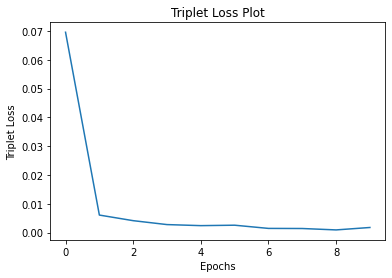

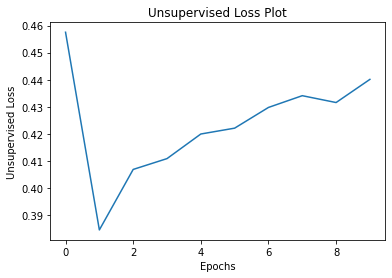

<Figure size 432x288 with 0 Axes>

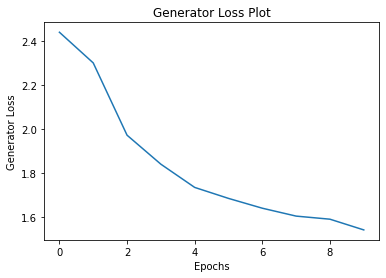

<Figure size 432x288 with 0 Axes>

In [ ]:

    # parser = argparse.ArgumentParser(description='PyTorch Improved GAN')
    # parser.add_argument('--batch-size', type=int, default=100, metavar='N',
    #                     help='input batch size for training (default: 64)')
    # parser.add_argument('--epochs', type=int, default=10, metavar='N',
    #                     help='number of epochs to train (default: 10)')
    # parser.add_argument('--lr', type=float, default=0.003, metavar='LR',
    #                     help='learning rate (default: 0.003)')
    # parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
    #                     help='SGD momentum (default: 0.5)')
    # parser.add_argument('--cuda', action='store_true', default=False,
    #                     help='CUDA training')
    # parser.add_argument('--seed', type=int, default=1, metavar='S',
    #                     help='random seed (default: 1)')
    # parser.add_argument('--log-interval', type=int, default=100, metavar='N',
    #                     help='how many batches to wait before logging training status')
    # parser.add_argument('--eval-interval', type=int, default=1, metavar='N',
    #                     help='how many epochs to wait before evaling training status')
    # parser.add_argument('--unlabel-weight', type=float, default=1, metavar='N',
    #                     help='scale factor between labeled and unlabeled data')
    # parser.add_argument('--logdir', type=str, default='./logfile', metavar='LOG_PATH', help='logfile path, tensorboard format')
    # parser.add_argument('--savedir', type=str, default='./models', metavar='SAVE_PATH', help = 'saving path, pickle format')
    # args = parser.parse_args()
    # args.cuda = args.cuda and torch.cuda.is_available()
    # seed=1
    # np.random.seed(seed)

mnisttrip=MNIST_triplet()
gan = ImprovedGAN(Generator(100), Discriminator(),mnisttrip, MnistLabel(10,10), MNISTunlab(), MnistTest())
gan.train_real()

In [ ]:
train_features=[]
test_features=[]
train_labels=[]
test_labels=[]

disc=Discriminator()
disc=torch.load('D_pr_16_1009.pkl')

# tr=MNISTunlab()
# for (i,j) in tr:
#   train_labels.append(j)
#   train_features.append(disc(i.cuda(),cuda=True))

unlabel_loader1 = DataLoader(MNISTunlab(), batch_size = 600,  drop_last=True, num_workers = 4)
for (i,j) in unlabel_loader1:
  train_labels+=j.tolist()
  train_features+=((disc(i.cuda(),cuda=True)).tolist())



# print(train_labels)
# print(len(train_labels)) 
# print(len(train_features[0]))
# print(len(train_features)) 



unlabel_loader1 = DataLoader(MnistTest(), batch_size = 200, drop_last=True, num_workers = 4)
for (i,j) in unlabel_loader1:
  test_labels+=j.tolist()
  test_features+=((disc(i.cuda(),cuda=True)).tolist())

print(test_labels)
print(len(test_labels)) 
print(len(test_features[0]))
print(len(test_features)) 




[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2, 5, 4, 7, 6, 7, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 2, 9, 9, 5, 5, 1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 5, 1, 4, 4, 7, 2, 3, 2, 7, 1, 8, 1, 8, 1, 8, 5, 0, 8, 9, 2, 5, 0, 1, 1, 1, 0, 9, 0, 3, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 5, 9, 3, 9, 0, 3, 6, 5, 5, 7, 2, 2, 7, 1, 2, 8, 4, 1, 7, 3, 3, 8, 8, 7, 9, 2, 2, 4, 1, 5, 9, 8, 7, 2, 3, 0, 4, 4, 2, 4, 1, 9, 5, 7, 7, 2, 8, 2, 6, 8, 5, 7, 7, 9, 1, 8, 1, 8, 0, 3, 0, 1, 9, 9, 4, 1, 8, 2, 1, 2, 9, 7, 5, 9, 2, 6, 4, 1, 5, 8, 2, 9, 2, 0, 4, 0, 0, 2, 8, 4, 7, 1, 2, 4, 0, 2, 7, 4, 3, 3, 0, 0, 3, 1, 9, 6, 5, 2, 5, 9, 2, 9, 3, 0, 4, 2, 0, 7, 1, 1, 2, 1, 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn= KNeighborsClassifier(n_neighbors=9)
knn.fit(train_features,train_labels)
res=knn.predict(test_features)
correct=(res==test_labels).sum()
print(correct)
print(len(test_labels))
print(correct/len(test_labels))

train_labels=np.asarray(train_labels)
test_labels=np.asarray(test_labels)


9716
10000
0.9716


In [ ]:
from sklearn.metrics import average_precision_score
from scipy.spatial.distance import cdist
Y = cdist(test_features[:5000],train_features)
ind = np.argsort(Y,axis=1)
prec = 0.0;
acc = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0];
# calculating statistics

# print(len(np.shape(test_features)[0]):))
for k in range(np.shape(test_features[:5000])[0]):
    class_values = train_labels[ind[k,:]]
    y_true = (test_labels[:5000][k] == class_values)
    y_scores = np.arange(y_true.shape[0],0,-1)
    ap = average_precision_score(y_true, y_scores)
    prec = prec + ap
    for n in range(len(acc)):
        a = class_values[0:(n+1)]
        counts = np.bincount(a)
        b = np.where(counts==np.max(counts))[0]
        if test_labels[:5000][k] in b:
            acc[n] = acc[n] + (1.0/float(len(b)))

prec = prec/float(np.shape(test_features[:5000])[0])
acc= [x / float(np.shape(test_features[:5000])[0]) for x in acc]
print("Final results: ")
print("mAP value: %.4f "% prec)


Final results: 
mAP value: 0.8953 


In [ ]:
prec1=prec
Y = cdist(test_features[5000:],train_features)
ind = np.argsort(Y,axis=1)
prec = 0.0;
acc = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0];
# calculating statistics

# print(len(np.shape(test_features)[0]):))
for k in range(np.shape(test_features[5000:])[0]):
    class_values = train_labels[ind[k,:]]
    y_true = (test_labels[5000:][k] == class_values)
    y_scores = np.arange(y_true.shape[0],0,-1)
    ap = average_precision_score(y_true, y_scores)
    prec = prec + ap
    for n in range(len(acc)):
        a = class_values[0:(n+1)]
        counts = np.bincount(a)
        b = np.where(counts==np.max(counts))[0]
        if test_labels[5000:][k] in b:
            acc[n] = acc[n] + (1.0/float(len(b)))

prec = prec/float(np.shape(test_features[5000:])[0])
acc= [x / float(np.shape(test_features[5000:])[0]) for x in acc]
print("Final results: ")
print("mAP value: %.4f "% prec)
prec2=prec

Final results: 
mAP value: 0.9530 


In [ ]:
print("Final avg mAP")
print((prec1+prec2)/2)

Final avg mAP
0.9241671653744923


In [ ]:
##pretraining
import os
os.chdir('/content/drive/My Drive/DL/EndSem/pretrained_32')

adversarial_loss = torch.nn.BCELoss()
cuda=True
# Initialize generator and discriminator
discriminator = Discriminator()
generator = Generator(100)

generator=generator.cuda()
discriminator=discriminator.cuda()
adversarial_loss=adversarial_loss.cuda()

dataloader = DataLoader(MNISTunlab(), batch_size = 100)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.003, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.003, betas=(0.5, 0.999))

for epoch in range(50):
    for i, (imgs, _) in enumerate(dataloader):
        
        # print(imgs)
        # Adversarial ground truths
        valid = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0).cuda()
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0).cuda()

        # Configure input
        real_imgs = imgs.cuda()

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        # z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 100))))

        # Generate a batch of images
        gen_imgs = generator(100,cuda=True)

        # Loss measures generator's ability to fool the discriminator
        # print(discriminator(gen_imgs,pretrain=True,cuda=True))
        g_loss = adversarial_loss(discriminator(gen_imgs,pretrain=True,cuda=True), valid)
        # optimizer_G.zero_grad()

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs,pretrain=True,cuda=True), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(),pretrain=True,cuda=True), fake)
        d_loss = (real_loss + fake_loss) / 2
        # optimizer_D.zero_grad()

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, 50, i, len(dataloader), d_loss.item(), g_loss.item())
        )
    torch.save(discriminator,'pretrained_32_D'+str(epoch)+".pkl")
    torch.save(generator,'pretrained_32_G'+str(epoch)+".pkl")

    


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw
Processing...
Done!
[Epoch 0/50] [Batch 0/600] [D loss: 0.751488] [G loss: 0.600828]

[Epoch 0/50] [Batch 1/600] [D loss: 0.688894] [G loss: 2.447407]
[Epoch 0/50] [Batch 2/600] [D loss: 0.457423] [G loss: 1.212205]
[Epoch 0/50] [Batch 3/600] [D loss: 0.164125] [G loss: 3.554856]
[Epoch 0/50] [Batch 4/600] [D loss: 0.057958] [G loss: 2.926473]
[Epoch 0/50] [Batch 5/600] [D loss: 0.012819] [G loss: 6.404612]
[Epoch 0/50] [Batch 6/600] [D loss: 0.154545] [G loss: 3.303911]
[Epoch 0/50] [Batch 7/600] [D loss: 2.859488] [G loss: 18.813271]
[Epoch 0/50] [Batch 8/600] [D loss: 0.094208] [G loss: 2.427182]
[Epoch 0/50] [Batch 9/600] [D loss: 0.863313] [G loss: 0.362939]
[Epoch 0/50] [Batch 10/600] [D loss: 0.106746] [G loss: 3.261362]
[Epoch 0/50] [Batch 11/600] [D loss: 0.181455] [G loss: 4.158714]
[Epoch 0/50] [Batch 12/600] [D loss: 0.129990] [G loss: 3.239583]
[Epoch 0/50] [Batch 13/600] [D loss: 0.235793] [G loss: 1.

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type LinearWeightNorm. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Streaming output truncated to the last 5000 lines.
[Epoch 41/50] [Batch 401/600] [D loss: 0.396813] [G loss: 1.487967]
[Epoch 41/50] [Batch 402/600] [D loss: 0.457684] [G loss: 1.507758]
[Epoch 41/50] [Batch 403/600] [D loss: 0.353937] [G loss: 1.718497]
[Epoch 41/50] [Batch 404/600] [D loss: 0.403946] [G loss: 1.806402]
[Epoch 41/50] [Batch 405/600] [D loss: 0.382067] [G loss: 1.760317]
[Epoch 41/50] [Batch 406/600] [D loss: 0.438784] [G loss: 1.568202]
[Epoch 41/50] [Batch 407/600] [D loss: 0.416424] [G loss: 1.760963]
[Epoch 41/50] [Batch 408/600] [D loss: 0.398047] [G loss: 1.901767]
[Epoch 41/50] [Batch 409/600] [D loss: 0.481770] [G loss: 1.541633]
[Epoch 41/50] [Batch 410/600] [D loss: 0.414608] [G loss: 1.808567]
[Epoch 41/50] [Batch 411/600] [D loss: 0.434108] [G loss: 1.747283]
[Epoch 41/50] [Batch 412/600] [D loss: 0.472369] [G loss: 1.375078]
[Epoch 41/50] [Batch 413/600] [D loss: 0.454903] [G loss: 1.499290]
[Epoch 41/50] [Batch 414/600] [D loss: 0.380128] [G loss: 1.54670